In [1]:
import tarfile
import pandas as pd
import numpy as np
from nilearn import plotting
import os
import nibabel as nib
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import math

%matplotlib inline
np.random.seed(1)

In [2]:
data_info = pd.read_csv('data_info.csv')

In [3]:
data_info['Normal'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(
    lambda x: 1 if x == 0 else 0)
data_info['NormalToMCI'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(
    lambda x: 1 if x == 1 else 0)
data_info['MCI'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(
    lambda x: 1 if x == 2 else 0)
data_info['AD'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(
    lambda x: 1 if x == 3 else 0)
data_info['OtherDementia'] = data_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].apply(
    lambda x: 1 if x == 4 else 0)

In [4]:
data_info.head()

,Unnamed: 0,filename,NACCMRFI,diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia,Normal,NormalToMCI,MCI,AD,OtherDementia
0,0,mri71_MPRAGE_T1_AX_20100921133637_15.nii.gz,mri71,3.0,0,0,0,1,0
1,1,mri3579_t1_fl2d_sag_20100610142105_3.nii.gz,mri3579,3.0,0,0,0,1,0
2,2,mri3579_MPRAGE_adni1mm_ipat_20100610142105_11....,mri3579,3.0,0,0,0,1,0
3,3,mri3579_ep2d_t1w_128_2mm_20100610142105_19.nii.gz,mri3579,3.0,0,0,0,1,0
4,4,mri3579_MPRAGE_adni1mm_ipat_20100610142105_13....,mri3579,3.0,0,0,0,1,0


### 1. Load data

In [5]:
number_files_loaded = 3
sample_list = data_info.iloc[:number_files_loaded, :]["filename"]
sample_data_list = list()
for filename in sample_list:
    # or is it better to use get_fdata()?
    a = nib.load("fs_t1/"+filename).get_data()
    sample_data_list.append(a)
sample_dataset = np.array(sample_data_list, dtype=np.float32)
batch_size, height, width, depth = sample_dataset.shape
channels = 1  # gray-scale instead of RGB
s = sample_dataset.reshape(number_files_loaded, 256, 256, 256, 1)

In [6]:
y = data_info.iloc[:number_files_loaded, 4:9]
y = np.array(y)
y[:5]

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]], dtype=int64)

### 2. Split the dataset to training and test sets

In [7]:
def split_train_test(data, test_ratio):
    """
    Generate shuffled indices to split the original dataset.

    Arguments: -- data: dataset to be handled, with shape (n, n_D0, n_H0, n_W0, n_C0) if input is X, (n, n_y) if input is Y
               -- test_ratio: percentage of the test set in the total dataset

    Returns: -- train_indices: a numpy array of the indices to be chosen for the training set 
                               with size len(data)-int(len(data)*test_ratio)
             -- test_indices: a numpy array of the indices to be chosen for the test set
                              with size int(len(data)*test_ratio)
    """
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return train_indices, test_indices

In [8]:
train_indices, test_indices = split_train_test(s, 0.4)
X_train_orig = s[train_indices]
X_test_orig = s[test_indices]
Y_train = y[train_indices]
Y_test = y[test_indices]

X_train = X_train_orig/255.
X_test = X_test_orig/255.

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 2
number of test examples = 1
X_train shape: (2, 256, 256, 256, 1)
Y_train shape: (2, 5)
X_test shape: (1, 256, 256, 256, 1)
Y_test shape: (1, 5)


### create placeholders

In [9]:
def create_placeholders(n_D0, n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_D0 -- scalar, depth of an input image
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_D0, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(shape=(None, n_D0, n_H0, n_W0, n_C0), dtype=tf.float32)
    Y = tf.placeholder(shape=(None, n_y), dtype=tf.float32)

    return X, Y

### initialize parameters

In [ ]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        [filter_depth, filter_height, filter_width, in_channels, out_channels]
                        W1 : [4, 4, 4, 1, 8]     
                        W2 : [2, 2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """

    tf.set_random_seed(1)

    W1 = tf.get_variable(
        "W1", [4, 4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable(
        "W2", [2, 2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

### forward propagation

In [10]:
def forward_propagation(X, parameters=None):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
#     W1 = parameters['W1']
#     W2 = parameters['W2']

    A1 = tf.layers.conv3d(X, filters=8, kernel_size=4,strides=1, padding="SAME", activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))

    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    # output_size = (3, 32, 32, 32, 8)
    P1 = tf.layers.max_pooling3d(A1, pool_size=8, strides=8, padding="SAME")

    # CONV2D: filters W2, stride 1, padding 'SAME'
    # output_size = (3, 32, 32, 32, 16)
    A2 = tf.layers.conv3d(P1, filters=16, kernel_size=2,strides=1, padding="SAME", activation=tf.nn.relu,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))

    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    # output_size = (3, 8, 8, 8, 16)
    P2 = tf.layers.max_pooling3d(A2, pool_size=4, strides=4, padding="SAME")

    # FLATTEN
    # output_size = (3, 8192)
    P2 = tf.contrib.layers.flatten(P2)

    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 5 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    # output_size = (3,5)
    Z3 = tf.contrib.layers.fully_connected(P2, 5, activation_fn=None)

    return Z3

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(256, 256, 256, 1, 5)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: X_train, Y: Y_train})
    print("Z3 = " + str(a))

### compute cost

In [ ]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y)
    cost = tf.reduce_mean(cost)

    return cost

### mini-batch

In [ ]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    # To make your "random" minibatches the same as ours
    np.random.seed(seed)
    m = X.shape[0]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        # START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        # START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

### model

In [19]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=3, minibatch_size=1, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    # to be able to rerun the model without overwriting tf variables
    ops.reset_default_graph()
    # to keep results consistent (tensorflow seed)
    tf.set_random_seed(1)
    # to keep results consistent (numpy seed)
    seed = 3
    (m, n_D0, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []                                        # To keep track of the cost

    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_D0, n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
#     parameters = initialize_parameters()

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initialize all the variables globally
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            # number of minibatches of size minibatch_size in the train set
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(
                X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _, temp_cost = sess.run([optimizer, cost], feed_dict={
                                        X: minibatch_X, Y: minibatch_Y})

                minibatch_cost += temp_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 2 == 0:
                print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy

Cost after epoch 0: 0.789459
Cost after epoch 2: 0.000000


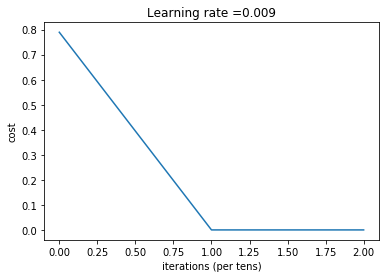

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [20]:
_, _ = model(X_train, Y_train, X_test, Y_test)

In [12]:
# GRADED FUNCTION: random_mini_batches